In [16]:
import os
import cv2
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
import warnings

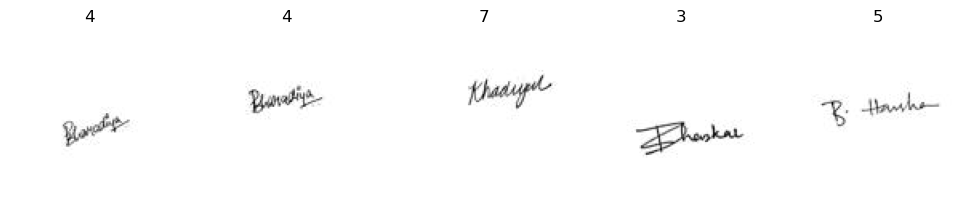

In [17]:
# Load images from folder and create labels
def load_images_from_folder(folder, label, target_size=(100, 100)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):  # Ensure processing only JPG files
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE) # Convert image to grayscale
            if img is not None:
                # Resize the image to 100x100 pixels
                resized_img = cv2.resize(img, target_size)
                images.append(resized_img)
                labels.append(label)
    return images, labels

folder_path = 'Signatures_cropped'
all_images = []
all_labels = []
for signature_folder in os.listdir(folder_path):
    signature_path = os.path.join(folder_path, signature_folder)
    signature_images, signature_labels = load_images_from_folder(signature_path, signature_folder)
    all_images.extend(signature_images)
    all_labels.extend(signature_labels)

# Function to display images
def display_images(image_list, title_list, cols=5):
    rows = len(image_list) // cols + int(len(image_list) % cols > 0)
    plt.figure(figsize=(cols * 2, rows * 2))
    for i, (image, title) in enumerate(zip(image_list, title_list)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Selecting 5 random images and their labels
selected_indices = random.sample(range(len(all_images)), 5)
selected_images = [all_images[i] for i in selected_indices]
selected_labels = [all_labels[i] for i in selected_indices]

# Displaying 5 random images
display_images(selected_images, selected_labels)

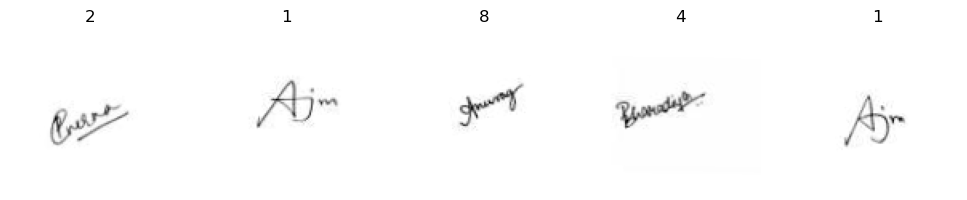

In [18]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)


images_array = np.array(all_images)
images_array = images_array.reshape((-1, ) + images_array.shape[1:] + (1,))

augmented_images = []
for img in images_array:
    img = img.reshape((1,) + img.shape)
    for _ in range(5):
        augmented_image = next(datagen.flow(img, batch_size=1))
        augmented_images.append(augmented_image[0].squeeze())

# Combine original and augmented images
combined_images = all_images + augmented_images

# Duplicate labels for augmented images
N = 5
augmented_labels = []
for label in all_labels:
    augmented_labels.extend([label] * N)

combined_labels = all_labels + augmented_labels

# Selecting 5 random augmented images and their labels
selected_augmented_indices = random.sample(range(len(augmented_images)), 5)
selected_augmented_images = [augmented_images[i] for i in selected_augmented_indices]
selected_augmented_labels = [augmented_labels[i] for i in selected_augmented_indices]

# Displaying 5 random augmented images
display_images(selected_augmented_images, selected_augmented_labels)

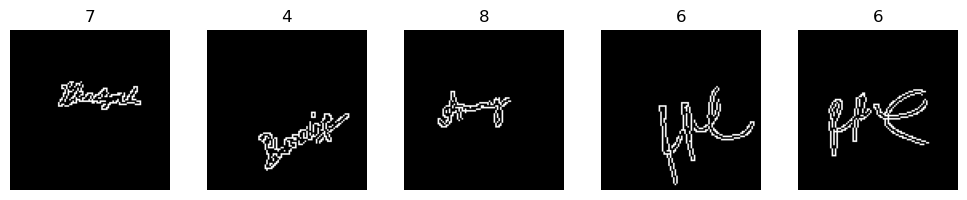

In [19]:
# Edge Detection and Thresholding
def apply_edge_detection_and_thresholding(images):
    processed_images = []
    for img in images:
        if img.dtype != 'uint8':
            img = img.astype('uint8')
        edges = cv2.Canny(img, 100, 200)
        _, thresh = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        processed_images.append(thresh)
    return processed_images

processed_images = apply_edge_detection_and_thresholding(combined_images)

# Resize images
def resize_images(images, size=(100, 100)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, size)
        resized_images.append(resized)
    return resized_images

final_images = resize_images(processed_images)

# Selecting 5 final images and their labels
selected_final_indices = random.sample(range(len(final_images)), 5)
selected_final_images = [final_images[i] for i in selected_final_indices]
selected_final_labels = [combined_labels[i] for i in selected_final_indices]

# Displaying 5 random final images
display_images(selected_final_images, selected_final_labels)

In [34]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(final_images, combined_labels, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=True, 
                                                    stratify=combined_labels)
X_train = np.array(X_train)
X_train = X_train.reshape(3072, -1)

X_test = np.array(X_test)
X_test = X_test.reshape(768, -1)

In [40]:
warnings.filterwarnings('ignore')

# Apply SMOTE to balance the classes
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Hyperparameters ranges
knn_params = {
    'n_neighbors': [10, 15, 20],
    'weights': ['uniform']
}

rf_params = {
    'n_estimators': [150, 200],
    'max_depth': [5, 8],
    'min_samples_split': [6, 10]
}

mlp_params = {
    'hidden_layer_sizes': [(50,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.05, 0.1]
}

# Define the models with hyperparameter grids
models = {
    'KNN': (Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=95)), ('classifier', KNeighborsClassifier())]), knn_params),
    'RandomForest': (Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=95)), ('classifier', RandomForestClassifier())]), rf_params),
    'NeuralNetwork': (Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=95)), ('classifier', MLPClassifier())]), mlp_params)
}

# Stratified K-Fold for cross-validation
stratified_k_fold = StratifiedKFold(n_splits=5)

# Train and evaluate each model with GridSearchCV
for name, (model_pipeline, params) in models.items():
    
    params = {'classifier__' + key: params[key] for key in params}
    grid_search = GridSearchCV(model_pipeline, params, cv=stratified_k_fold, scoring='accuracy')
    grid_search.fit(X_train_smote, y_train_smote)
    best_model = grid_search.best_estimator_
    
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train_smote)
    
    print(f"{name} Best Parameters:")
    print(grid_search.best_params_)
    
    # Classification report on test data
    print(f"{name} Test Data Classification Report:")
    print(classification_report(y_test, y_pred_test))

    # Classification report on train data
    print(f"{name} Training Data Classification Report:")
    print(classification_report(y_train_smote, y_pred_train))
    
    # Save the best model pipeline
    model_filename = f'{name.lower()}_best_signature_model_pipeline.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(best_model, file)

    print(f'{name} pipeline saved as {model_filename}')

KNN Best Parameters:
{'classifier__n_neighbors': 10, 'classifier__weights': 'uniform'}
KNN Test Data Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.90      0.89        96
           2       0.70      0.62      0.66        48
           3       0.62      0.47      0.53        96
           4       0.52      0.66      0.58        96
           5       0.94      0.88      0.91        96
           6       0.92      0.79      0.85        96
           7       0.49      0.44      0.46        48
           8       0.77      0.93      0.84        96
           9       0.93      1.00      0.96        96

    accuracy                           0.77       768
   macro avg       0.75      0.74      0.74       768
weighted avg       0.77      0.77      0.77       768

KNN Training Data Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.93      0.93       384
           2       0.